In [1]:
import igraph as ig
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import leidenalg as la
from sklearn.metrics import normalized_mutual_info_score as nmi

# Helitron similarity network (HSN) analysis

## Load info and construct the network

In [2]:
node_info = pd.read_table("data/node_info.tsv")
edge_list = pd.read_table("data/helitron.blast.short.tsv")

In [3]:
G = ig.Graph.DataFrame(edge_list, vertices= node_info, use_vids=False, directed = True)
G.to_undirected(mode = "collapse", combine_edges = "mean")

In [4]:
#G.write("data/network.graphml", format = "graphml")

In [5]:
# Find the biggest component
C = G.connected_components().giant()

In [6]:
#C.write("data/biggest_component.graphml", format = "graphml")

## Basic information of the network

In [7]:
G.ecount()

7693020

In [8]:
G.vcount()

108436

In [9]:
G.density()

0.00130853060418477

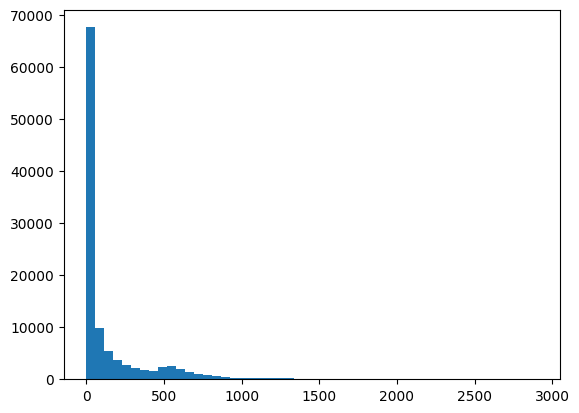

In [10]:
hist, bins, _ = plt.hist(G.degree(), bins=50)

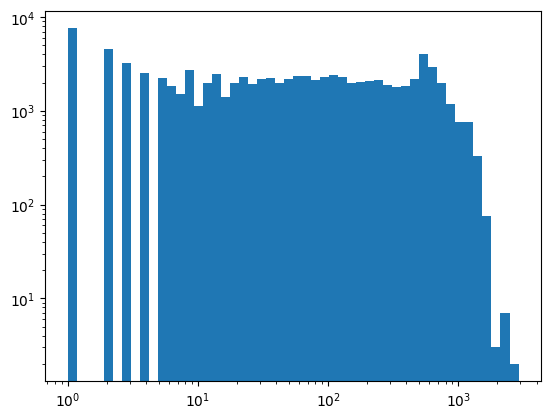

In [11]:
logbins = np.logspace(np.log10(bins[0]+1), np.log10(bins[-1]),len(bins))
plt.xscale('log')
plt.yscale('log')
plt.hist(G.degree(), bins=logbins)
plt.show()

In [12]:
# Number of nodes without edges
G.degree().count(0)

18160

# Basic information of the biggest component

In [13]:
C.ecount()

7557671

In [14]:
C.vcount()

81521

In [15]:
C.density()

0.0022744914496645773

In [16]:
C.ecount()/G.ecount()

0.9824062591803999

In [17]:
C.vcount()/G.vcount()

0.7517890737393486

In [18]:
np.mean(C.degree())

185.41654297665633

In [19]:
np.std(C.degree())

271.0505014088374

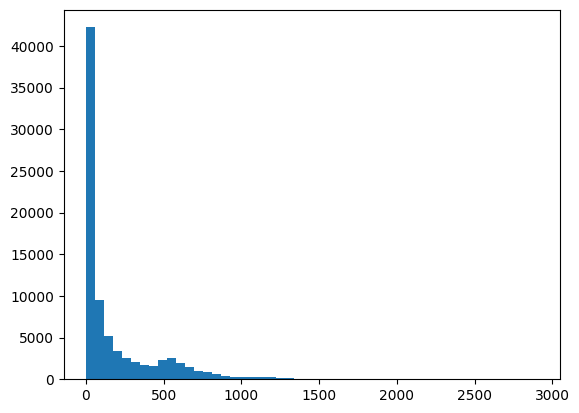

In [20]:
hist, bins, _ = plt.hist(C.degree(), bins=50)

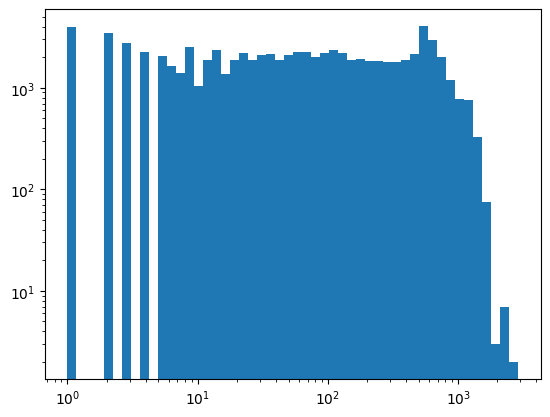

In [21]:
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]),len(bins))
plt.xscale('log')
plt.yscale('log')
plt.hist(C.degree(), bins=logbins)
plt.show()

# Information of components

In [22]:
len(G.connected_components())

20044

In [23]:
component_size = [len(C) for C in G.connected_components()]

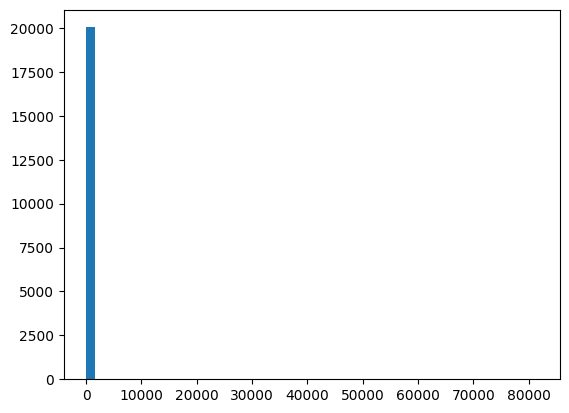

In [24]:
hist, bins, _ = plt.hist(component_size, bins=50)

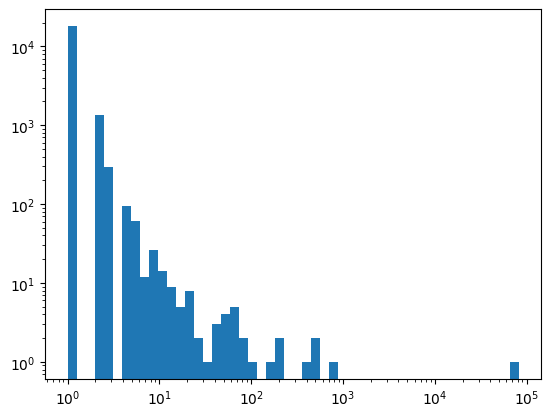

In [25]:
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]),len(bins))
plt.xscale('log')
plt.yscale('log')
plt.hist(component_size, bins=logbins)
plt.show()

# Modularity of partitions by families

In [26]:
family_assignment = C.vs()["family"]
families = list(set(family_assignment))
family_to_int = dict(zip(families, [i for i in range(len(families))]))
family_int_assignment = [family_to_int[family] for family in family_assignment]

In [27]:
family_modularity = C.modularity(membership=family_int_assignment, weights = "bitscore")

In [28]:
family_modularity

0.6938471936151556

In [29]:
# Number of families
len(families)

69

# Community detection

In [30]:
detected_partition = la.find_partition(C, la.ModularityVertexPartition, weights = "bitscore")

In [31]:
# Number of communities
len(set(detected_partition.membership))

99

In [32]:
C.modularity(membership = detected_partition.membership, weights = "bitscore")

0.8506675910680285

# Comparison between family and detected community

In [33]:
nmi(family_int_assignment, detected_partition.membership)

0.6936318698747114

In [34]:
def assignment_matrix(assignment1, assignment2):
    if (len(assignment1) != len(assignment2)):
        raise Exception("Assignment vectors must be equal in lengths")
    N = len(assignment1)
    matrix = np.zeros((len(set(assignment1)), len(set(assignment2))))
    for i in range(N):
        matrix[assignment1[i], assignment2[i]] += 1
    return matrix

In [35]:
assignment = assignment_matrix(family_int_assignment, detected_partition.membership)
np.savetxt("assignment.csv", assignment, delimiter=",")

# Centrality measures of nodes

In [36]:
detected_partition.